## Importing important libraries

In [88]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import IPython.display as ipd
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, cross_val_predict
import os


from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.feature_selection import RFE

## Importing train and test dataset
#### Redefining column values for better assessment and breaking down date
#### Days and weekdays are Cyclic feature encoded

In [89]:
data_org = pd.read_csv("Train_Data.csv")
data_org.head()

,date,campaign,adgroup,ad,impressions,clicks,cost,conversions,revenue
0,01-08-2020,campaign 1,adgroup 1,ad 1,24,6,0.08,0,0.00
1,01-08-2020,campaign 1,adgroup 2,ad 1,1,0,0.00,0,0.00
2,01-08-2020,campaign 1,adgroup 3,ad 1,13,4,0.04,0,0.00
3,01-08-2020,campaign 1,adgroup 4,ad 1,5,4,0.08,0,0.00
4,01-08-2020,campaign 1,adgroup 1,ad 2,247,126,1.29,4,925.71


In [90]:
data_org.nunique()
# campaign has only one unique value so we can consider it as redundant column and drop it

date            212
campaign          1
adgroup           4
ad               70
impressions     571
clicks          355
cost            810
conversions      49
revenue        1223
dtype: int64

In [91]:
data_org.isnull().sum() # checking for null values

date           0
campaign       0
adgroup        0
ad             0
impressions    0
clicks         0
cost           0
conversions    0
revenue        0
dtype: int64

<AxesSubplot:>

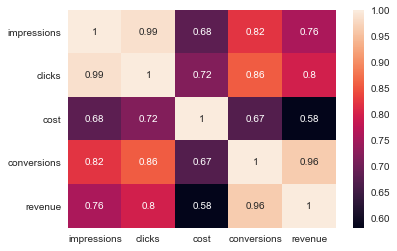

In [92]:
sns.heatmap(data_org.corr(),annot=True) 

#### clicks and impression are highly correlated and it can be observed that revenue in highly correlated to conversions

In [93]:
# campaign column had a constant value
data_org.pop("campaign")

from datetime import datetime, timedelta
from matplotlib import dates as mpl_dates

plt.style.use('seaborn')

data_org['date'] = pd.to_datetime(data_org['date'], dayfirst=True,format = "%d-%m-%Y")



In [94]:
data1 = data_org.groupby("date").sum()
data1.head()

,impressions,clicks,cost,conversions,revenue
date,,,,,
2020-08-01,1754,797,8.46,16,2384.92
2020-08-02,1598,809,8.51,24,4275.25
2020-08-03,1588,733,8.07,22,3441.02
2020-08-04,1559,725,8.20,19,4378.93
2020-08-05,1368,668,7.49,14,2634.79


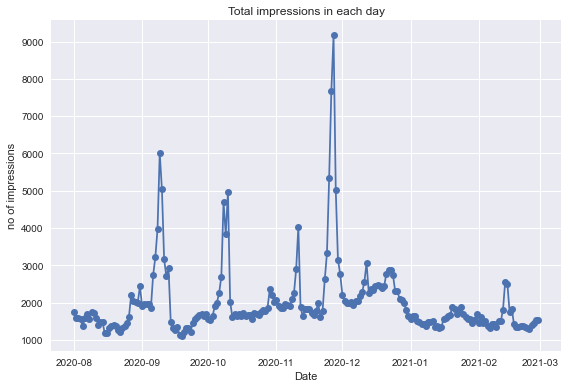

In [95]:
imp_date = data1.index
imp_close = data1['impressions']

plt.plot_date(imp_date, imp_close, linestyle='solid')

plt.gcf()

plt.title('Total impressions in each day')
plt.xlabel('Date')
plt.ylabel('no of impressions')

plt.tight_layout()

plt.show()

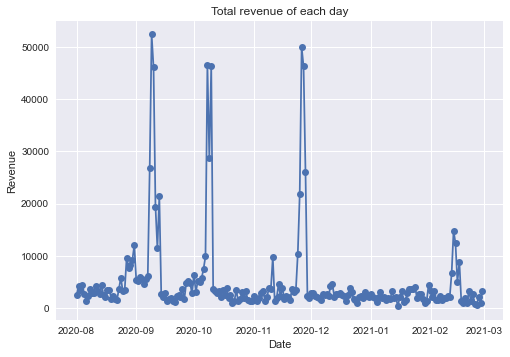

In [96]:
price_date = data1.index
price_close = data1['revenue']

plt.plot_date(price_date, price_close, linestyle='solid')

plt.title('Total revenue of each day')
plt.xlabel('Date')
plt.ylabel('Revenue')

plt.show()


<AxesSubplot:xlabel='adgroup'>

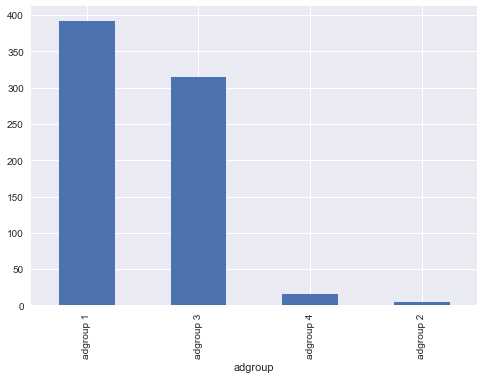

In [97]:
data_org.groupby('adgroup').mean()['revenue'].sort_values(ascending=False).plot(kind='bar')

revenue depends upon adgroups distinctively

In [98]:
data_org["adgroup"] = data_org["adgroup"].str.replace("adgroup ","")
data_org["ad"] = data_org["ad"].str.replace("ad ","")

data_org['dayofweek'] = data_org['date'].dt.dayofweek
data_org['day'] = data_org['date'].dt.day


# Encoding month , day and week of the day

data_org['weekday_sin'] = np.sin((data_org.dayofweek-1)*(2.*np.pi/7))
data_org['weekday_cos'] = np.cos((data_org.dayofweek-1)*(2.*np.pi/7))

data_org['day_sin'] = np.sin((data_org.day-1)*(2.*np.pi/data_org['date'].dt.days_in_month))
data_org['day_cos'] = np.cos((data_org.day-1)*(2.*np.pi/data_org['date'].dt.days_in_month))

data_org.drop(["date","dayofweek","day"],axis=1,inplace = True)

data_org['CTR'] = ( data_org.clicks / data_org.impressions )
# data_org['CPA'] = ( data_org.cost / data_org.conversions )

# # handling NAN and inf values
# data_org['CPA'] = data_org['CPA'].replace(np.inf, np.nan)
# data_org['CPA'] = data_org['CPA'].replace(np.nan, data_org['CPA'].mean()) 

data_org.drop(['impressions', 'clicks'],axis='columns',inplace = True)


data_org = data_org.astype({'adgroup': 'category'})

data_org.head()

,adgroup,ad,cost,conversions,revenue,weekday_sin,weekday_cos,day_sin,day_cos,CTR
0,1,1,0.08,0,0.00,-0.433884,-0.900969,0.0,1.0,0.250000
1,2,1,0.00,0,0.00,-0.433884,-0.900969,0.0,1.0,0.000000
2,3,1,0.04,0,0.00,-0.433884,-0.900969,0.0,1.0,0.307692
3,4,1,0.08,0,0.00,-0.433884,-0.900969,0.0,1.0,0.800000
4,1,2,1.29,4,925.71,-0.433884,-0.900969,0.0,1.0,0.510121


## Shaping the test dataset

In [99]:
test_data = pd.read_csv("Test_Data.csv")

test_data["adgroup"] = test_data["adgroup"].str.replace("adgroup ","")
test_data["ad"] = test_data["ad"].str.replace("ad ","")

test_data['date'] = pd.to_datetime(test_data['date'], dayfirst=True,format = "%d-%m-%Y")
test_data['dayofweek'] = test_data['date'].dt.dayofweek
test_data['day'] = test_data['date'].dt.day


test_data['weekday_sin'] = np.sin((test_data.dayofweek-1)*(2.*np.pi/7))
test_data['weekday_cos'] = np.cos((test_data.dayofweek-1)*(2.*np.pi/7))

test_data['day_sin'] = np.sin((test_data.day-1)*(2.*np.pi/test_data['date'].dt.days_in_month))
test_data['day_cos'] = np.cos((test_data.day-1)*(2.*np.pi/test_data['date'].dt.days_in_month))

test_data.drop(["date","dayofweek","day","campaign"],axis=1,inplace = True)

test_data['CTR'] = ( test_data.clicks / test_data.impressions )
# test_data['CPA'] = ( test_data.cost / test_data.conversions ) # model getting overfitted need to lookinto this 


# test_data['CPA'] = test_data['CPA'].replace(np.inf, np.nan)
# test_data['CPA'] = test_data['CPA'].replace(np.nan, test_data['CPA'].mean())

test_data.drop(['impressions' , 'clicks'],axis='columns',inplace = True)

test_data = test_data.astype({'adgroup': 'category'})

test_data.head()

,adgroup,ad,cost,conversions,weekday_sin,weekday_cos,day_sin,day_cos,CTR
0,1,1,0.58,1,-0.781831,0.62349,0.0,1.0,0.404959
1,3,1,0.17,0,-0.781831,0.62349,0.0,1.0,0.545455
2,4,1,0.05,0,-0.781831,0.62349,0.0,1.0,0.600000
3,2,1,0.01,0,-0.781831,0.62349,0.0,1.0,0.500000
4,2,2,0.01,0,-0.781831,0.62349,0.0,1.0,0.333333


### Checking skewed - ness of required variable

<AxesSubplot:xlabel='revenue', ylabel='Density'>

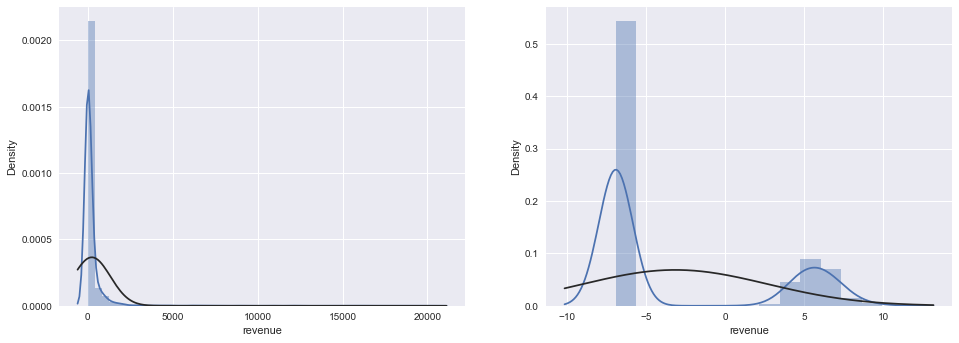

In [100]:
fig, ax = plt.subplots(1,2)
width, height = fig.get_size_inches()
fig.set_size_inches(width*2, height)
sns.distplot(data_org['revenue'], ax=ax[0], fit=norm)
sns.distplot(np.log(data_org[('revenue')]+0.001), ax=ax[1], fit= norm)

<AxesSubplot:xlabel='revenue', ylabel='Density'>

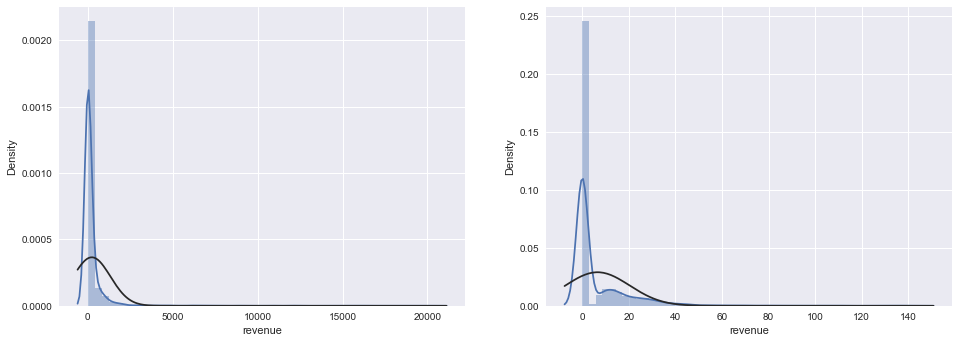

In [101]:
fig, ax = plt.subplots(1,2)
width, height = fig.get_size_inches()
fig.set_size_inches(width*2, height)
from scipy import stats
sns.distplot(data_org['revenue'], ax=ax[0], fit=norm)
sns.distplot(np.sqrt(data_org[('revenue')]), ax=ax[1], fit= norm)

In [102]:
(data_org.revenue).skew()

11.661764710607615

In [103]:
(np.sqrt(data_org.revenue)).skew()

3.8480900696590754

In [104]:
(np.log(data_org['revenue'] + 0.001)).skew() # log method bring skewness down -> needs to be implemented

0.9354186402597575

In [105]:
data_org.revenue = round(np.sqrt(data_org.revenue),2)


from sklearn.model_selection import train_test_split
y = data_org['revenue']
X = data_org.drop(['revenue'],axis = 1)

In [121]:
from sklearn.preprocessing import StandardScaler

scaler2 = StandardScaler()

X_scaled = scaler2.fit_transform(X)
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['mse'],
    'learning_rate': 0.3,
    'feature_fraction': 0.67,
    'bagging_fraction': 0.8,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 9,
    "num_leaves": 35,  
    "max_bin": 150,
    "num_iterations": 500,
    "n_estimators": 80
}
from lightgbm import LGBMRegressor

model = LGBMRegressor(**hyper_params)

model.fit(X_scaled, y)

yhat = model.predict(X_scaled,num_iteration=model.best_iteration_)


[LightGBM] [Warning] feature_fraction is set=0.67, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.67
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.67, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.67
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [122]:
model.score(X_scaled,y) # over-fitted

0.9982594058596661

In [123]:
from sklearn.metrics import mean_squared_error as mse

MSE = mse(np.square(y), np.square(yhat))
RMSE = np.sqrt(MSE)

RMSE

90.4246830558815

In [124]:
final_pred2 = model.predict(scaler2.transform(test_data),num_iteration=model.best_iteration_)

In [125]:
prediction = pd.DataFrame(np.square(final_pred2), columns=['revenue']).reset_index()

prediction.pop("index")

prediction.to_csv('revenue-2.csv',index = False)

<AxesSubplot:ylabel='Density'>

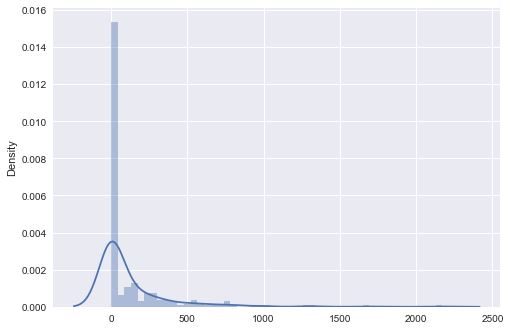

In [126]:
sns.distplot(np.square(final_pred2))

In [ ]:
## As of now the score of hackathon is 141(RMSE) 